## Second level GLM analysis

This script performs group level modeling of BOLD response. Script features: 
- loads statistical maps from first level GLM analysis
- discard data from excluded subjects
- performs second level GLM analysis

---
**Last update**: 19.02.2020 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

import nibabel as nib
from nilearn import plotting, datasets
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix, get_clusters_table
from scipy.stats import norm

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.plotting import plot_stat_maps_grid

In [2]:
def plot_stat_map(stat_map, height_control='fdr', p_val=0.01, cluster_threshold=15, title=''):
    '''Threshold and plot statistical map.
    
    Args:
        stat_map (nibabel.nifti1.Nifti1Image): 
            Statistical map from 1st or 2nd level GLM analysis.
        height_control (str, optional): 
            Specifies type of multiple comparison correction.
        p_val (float, optional): 
            Specifies p-value threshold for statistal map.
        cluster_threshold (int, optional): 
            Threshold for minimal size cluster of voxels.  
        title (str, optional):
            Figure title.
    '''
    cut_coords = (-15, -10, 3, 22, 38, 52)
    display_mode = 'z'

    # Load MNI template
    mni152nlin2009c = 'mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/temp.nii.gz'
    bg_img = nib.load(mni152nlin2009c)
    # bg_img = datasets.load_mni152_template()

    _, threshold = map_threshold(
        stat_map,
        alpha=p_val,
        height_control=height_control,
        cluster_threshold=cluster_threshold)

    fig, ax = plt.subplots(facecolor='k', figsize=(20, 5))
    plotting.plot_stat_map(
        stat_map,
        bg_img=bg_img,
        axes=ax,
        threshold=threshold,
        colorbar=True,
        display_mode=display_mode,
        cut_coords=cut_coords,
        title=title + f' ({height_control}; p<{p_val})')

def load_first_level_stat_maps(path):
    '''Load statistical maps (first level GLM output).
    
    Args:
        path (str): Path to directory where first level output is stored. Note that files should 
            follow BIDS-like naming convention, i.e. sub-<sub>_task-<task>_statmap.nii
            
    Returns: 
        (list): List of size n_conditions x n_subjects. First index denotes task condition. 
            Conditions are coded 0 for reward and 1 for punishment.
    '''
    tmap_files = [sorted([os.path.join(path, file) 
                          for file in os.listdir(path) if task in file]) 
                  for task in ['prlrew', 'prlpun']]

    tmap_imgs = []
    for con_idx in range(n_conditions):
        tmap_img_con = []
        for sub_idx in range(n_subjects):
            tmap_img_con.append(nib.load(tmap_files[con_idx][sub_idx]))
        tmap_imgs.append(tmap_img_con)
    
    return tmap_imgs

In [3]:
# Directory to save second level output
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/nistats/second_level_output')
os.makedirs(path_out, exist_ok=True)

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

Before constructing second level GLM, data from excluded subjects is discarded. To exclude subjects, filter vectors are used:
- `ok_all`: True / False vector of length `n_subjects` specifying if given subject should be included in second level analysis
- `ok_index`: vector of indices for included subjects
- `n_subjects_ok`: final group size, number of included subjects (`len(ok_index) is n_subjects_ok`)

In [4]:
path_nistats = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats')
path_first_level_output = os.path.join(path_nistats, 'first_level_output')
path_exclusion_csv = os.path.join(path_nistats, 'exclusion/exclusion.csv')

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_all = df_exclusion['ok_all']
ok_index = df_exclusion.index[ok_all]
n_subjects_ok = ok_all.sum()

## Group analysis

Here, group analysis is performed for model-based prediction error regressor, outcome onset regressor and button press regressor. Data from subjects excluded from the analysis is discarded at this point. Second level GLMs are created and fitted, then the resultant statistical map is displayed on the MNI152 non-linear asymmetric template (version 2009c; default template for fmriprep).

### **Effect 1**: *Difference in prediction error coding depending on outcome valence*

Here, we are interested if prediction error processing differed between reward and punishment condition. We used `pred_err` statistical maps from first level GLM. We separately modeled difference between conditions and within subject effect of repeated measures.

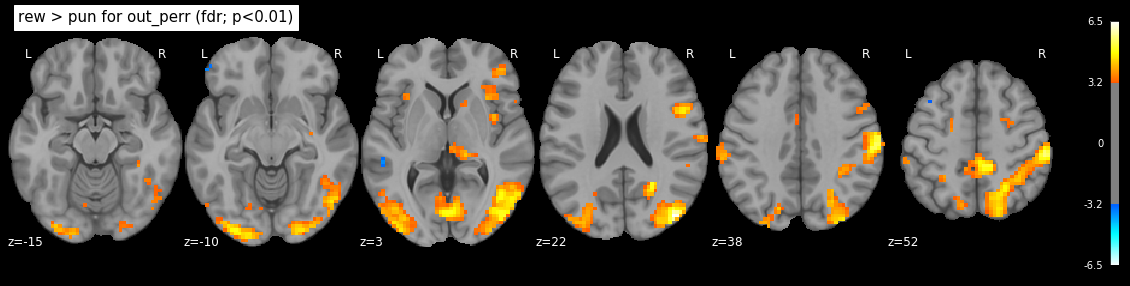

In [14]:
# Load stat-map images (first level output)
contrast = 'out_perr'
path_contrast = os.path.join(path_first_level_output, contrast)
stat_maps = load_first_level_stat_maps(path_contrast)

# Filter out excluded subjects
stat_maps_ok = [[stat_maps_condition[i] for i in ok_index] for stat_maps_condition in stat_maps]

# Define second level GLM
second_level_input = [stat_map for con_stat_maps in stat_maps_ok for stat_map in con_stat_maps]
second_level_model = SecondLevelModel(smoothing_fwhm=None)

# Create second level design matrix
effect_con = np.array([1] * n_subjects_ok + [-1] * n_subjects_ok)[:, np.newaxis]
effect_sub = np.vstack((np.eye(n_subjects_ok), np.eye(n_subjects_ok)))
design_matrix = pd.DataFrame(
    np.hstack((effect_con, effect_sub)),
    columns=['rew vs pun'] + [meta['dim1'][i] for i in ok_index]
)

# Fit second level model
second_level_model.fit(second_level_input, design_matrix=design_matrix)

# Compute statistical map for difference between conditions contrast
stat_map_2nd = second_level_model.compute_contrast('rew vs pun', output_type='z_score')

plot_stat_map(stat_map_2nd, title=f'rew > pun for {contrast}')

### **Effect 2**: *Combined effect of prediction error coding*
Which brain structures scale their BOLD activity according to magnitude of prediction error regardless of outcome valence?
### **Effect 3**: *Combined effect of outcome onset (feedback)*
Which brain structures respond to receiving feedback vs baseline regardless of outcome valence?
### **Effect 4**: *Combined effect of difference betweem left and right button press*
Which brain structures invoke left button presses and supress their activity for right button press (or vice versa) regardless of outcome valence?

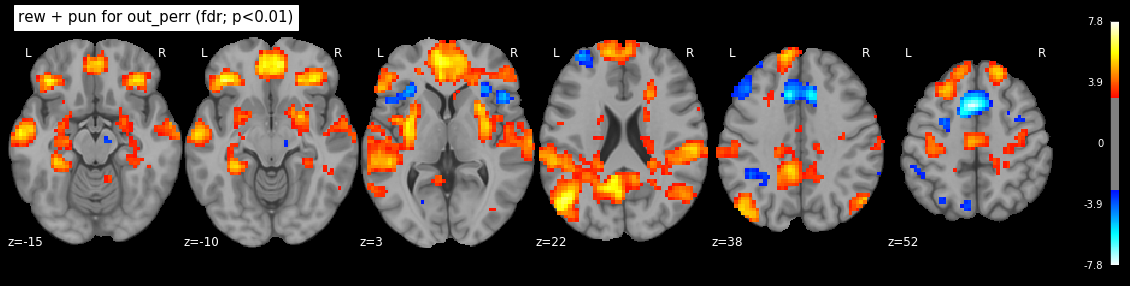

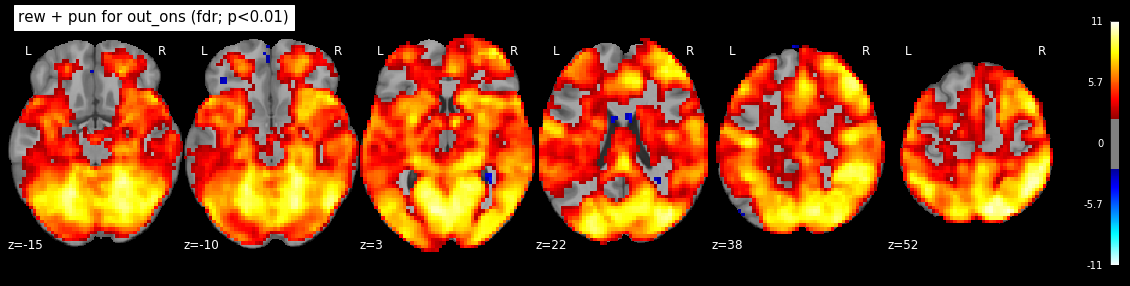

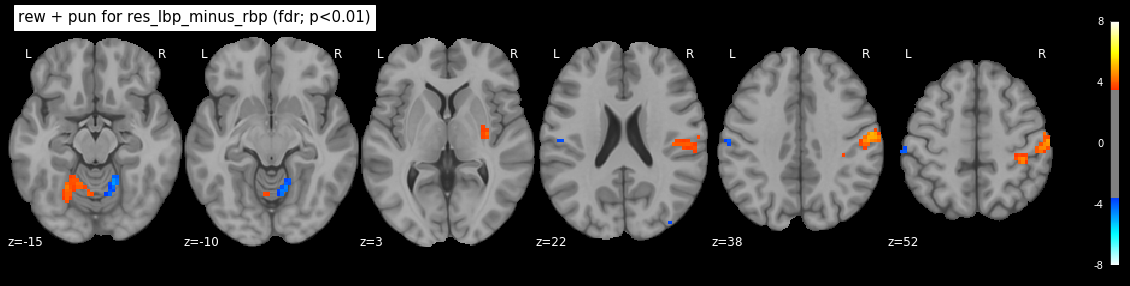

In [13]:
for contrast in ['out_perr', 'out_ons', 'res_lbp_minus_rbp']:
    # Load stat-map images (first level output)
    path_contrast = os.path.join(path_first_level_output, contrast)
    stat_maps = load_first_level_stat_maps(path_contrast)

    # Filter out excluded subjects
    stat_maps_ok = [[stat_maps_condition[i] for i in ok_index] for stat_maps_condition in stat_maps]

    # Define second level GLM
    second_level_input = [stat_map for con_stat_maps in stat_maps_ok for stat_map in con_stat_maps]
    second_level_model = SecondLevelModel(smoothing_fwhm=None)

    # Create second level design matrix
    effect_main = np.array([1] * n_subjects_ok * n_conditions)[:, np.newaxis]
    design_matrix = pd.DataFrame(effect_main, columns=['rew + pun'])

    # Fit second level model
    second_level_model.fit(second_level_input, design_matrix=design_matrix)

    # Compute statistical map for difference between conditions contrast
    stat_map_2nd = second_level_model.compute_contrast('rew + pun', output_type='z_score')

    plot_stat_map(stat_map_2nd, title=f'rew + pun for {contrast}')    

In [15]:
from nistats.reporting import get_clusters_table

In [21]:
contrast = 'out_perr'

# Load stat-map images (first level output)
path_contrast = os.path.join(path_first_level_output, contrast)
stat_maps = load_first_level_stat_maps(path_contrast)

# Filter out excluded subjects
stat_maps_ok = [[stat_maps_condition[i] for i in ok_index] for stat_maps_condition in stat_maps]

# Define second level GLM
second_level_input = [stat_map for con_stat_maps in stat_maps_ok for stat_map in con_stat_maps]
second_level_model = SecondLevelModel(smoothing_fwhm=None)

# Create second level design matrix
effect_main = np.array([1] * n_subjects_ok * n_conditions)[:, np.newaxis]
design_matrix = pd.DataFrame(effect_main, columns=['rew + pun'])

# Fit second level model
second_level_model.fit(second_level_input, design_matrix=design_matrix)

# Compute statistical map for difference between conditions contrast
stat_map_2nd = second_level_model.compute_contrast('rew + pun', output_type='z_score')

get_clusters_table(stat_map_2nd, 0.001, cluster_threshold=5, min_distance=8.0)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-12.0,-57.0,16.5,6.894884,1464592
1,1a,-6.0,48.0,-1.0,6.844594,
2,1b,-39.0,33.0,-11.5,6.741515,
3,1c,-48.0,-66.0,27.0,6.705320,
4,2,-42.0,42.0,41.0,1.730561,504
5,3,-3.0,-84.0,-43.0,1.692544,409
6,4,6.0,27.0,76.0,1.403708,283
7,5,-9.0,9.0,83.0,1.382965,157
8,6,-3.0,-72.0,65.5,1.364939,157
9,7,24.0,9.0,76.0,1.353093,315
